#Natural Language Processing with Disaster Tweets

From kaggle's [Predict which Tweets are about real disasters and which ones are not](https://www.kaggle.com/c/nlp-getting-started/data).

In [1]:
# Get access to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-07b6c916-afff-9930-3daf-c687dadef5b8)


In [2]:
# Import dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import io
import zipfile
import datetime
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import TextVectorization

#Explore data from kaggle


In [3]:
local_file = files.upload()

Saving nlp_getting_started.zip to nlp_getting_started.zip


In [4]:
zip_file = zipfile.ZipFile(io.BytesIO(local_file['nlp_getting_started.zip']), "r")
zip_file.extractall()
zip_file.close()

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.tail(10)

,id,keyword,location,text,target
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [7]:
# Texts labelled with '1' talk about disaters  
train_df['text'][7612]

'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'

In [8]:
# Shuffle train_df 
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# No targets in test_df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# View target '0' to '1' balance  
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# Visualize random examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():# Turn dataframe values into tuples (5 per)
  _, text, target = row # Get text/target, get rid of indices
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
WHITE AMERICANS ARE THE BIGGEST THREAT IN THE WORLD. DUH https://t.co/7PaOvYzTtw

---

Target: 1 (real disaster)
Text:
Carmike Cinemas on Antioch Shooting: 'We Are Grateful' for Staff and First Responders Safety Is 'Highest Priority' http://t.co/BehfHspPud

---

Target: 0 (not real disaster)
Text:
Shark boy and lava girl for the third time today. I guess this is what having kids feelings like. ??????

---

Target: 1 (real disaster)
Text:
@AdamTuss and is the car that derailed a 5000 series by chance. They used to have issues w/ wheel climbing RE: 1/2007 Mt. Vern Sq derailment

---

Target: 1 (real disaster)
Text:
Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/tyyfG4qQvM

---



# Preprocess the data

In [12]:
# Split data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, random_state=42)

In [13]:
# View splits
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [14]:
# View sentences
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [15]:
# View their labels
train_labels[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

## Convert texts to numbers

Numerical representation of sentences.

In [16]:
# Get average number of tokens/words per tweet
round(sum([len(i.split()) for i in train_sentences])), round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

(102087, 15)

In [17]:
# Text vectorization/tokenization
max_vocab_length = 10000 # Number of most common words in used vocabulary 
max_length = 15 # Length of token sequences (average of 15)

vectorizer = TextVectorization(max_tokens=max_vocab_length, output_mode='int', # Map tokens to intergers
                               output_sequence_length=max_length)

In [18]:
# Adapt vectorizer to the training data
vectorizer.adapt(train_sentences)

In [19]:
# Get unique word vocabulary
words_in_vocab = vectorizer.get_vocabulary()
print(words_in_vocab)

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for', 'on', 'you', 'my', 'with', 'it', 'that', 'at', 'by', 'this', 'from', 'be', 'are', 'was', 'have', 'like', 'as', 'up', 'so', 'just', 'but', 'me', 'im', 'your', 'not', 'amp', 'out', 'its', 'will', 'an', 'no', 'has', 'fire', 'after', 'all', 'when', 'we', 'if', 'now', 'via', 'new', 'more', 'get', 'or', 'about', 'what', 'he', 'people', 'news', 'been', 'over', 'one', 'how', 'dont', 'they', 'who', 'into', 'were', 'do', 'us', '2', 'can', 'video', 'emergency', 'there', 'disaster', 'than', 'police', 'would', 'his', 'still', 'her', 'some', 'body', 'storm', 'crash', 'burning', 'suicide', 'back', 'man', 'california', 'why', 'time', 'them', 'had', 'buildings', 'rt', 'first', 'cant', 'see', 'got', 'day', 'off', 'our', 'going', 'nuclear', 'know', 'world', 'bomb', 'fires', 'love', 'killed', 'go', 'attack', 'youtube', 'dead', 'two', 'families', '3', 'train', 'full', 'being', 'war', 'many', 'today', 'think', 'only', 'car', 'accident', 'l

## Create an Embedding Layer

Numerical representation of words to be learned during training.

In [20]:
tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, # The size of the embedding vector per token
                             embeddings_initializer='uniform', # Random initializer of embedding matrix
                             input_length=max_length)

#Naive Bayes with scikit-learn

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

naive_bayes = Pipeline([("tfidf", TfidfVectorizer()), # Tokenize words with tfidf
                        ("clf", MultinomialNB())]) # Model the text with clf

# Fit the model
naive_bayes.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate the model accuracy
naive_score = naive_bayes.score(val_sentences, val_labels)
naive_score

0.7926509186351706

In [23]:
# View the model predictions
naive_preds = naive_bayes.predict(val_sentences)
naive_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

##Create metrics and callback functions

In [24]:
# Function to evaluate accuracy, precision, recall and f1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate using "weighted" average (given slight label imbalance)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")# underscore skips 'support'
  # Create a results dictionary for dataframes
  model_metrics = {"accuracy": accuracy,
                   "precision": precision,
                   "recall": recall,
                   "f1": f1}

  return model_metrics

In [25]:
# Metrics function to compare models 
def compare_results(model_1, model_2):
  for key, value in model_1.items():
    print(f"model_1 {key}: {value:.2f}, model_2 {key}: {model_2[key]:.2f}, Difference: {model_2[key]-value:.2f}")

In [26]:
# Get naive_bayes results
naive_results = calculate_metrics(y_true=val_labels, y_pred=naive_preds)
naive_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [27]:
# Create TensorBoard callback function to log results for visualization
def tensorboard_callback(dir_name, experiment_name):
  # Store log files (dir_name, experiment_name, datetime) to filepath "dir_name/experiment_name/current_datetime/" 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  
  print(f"Saving TensorBoard log files to: {log_dir}")
  
  return tensorboard_callback

In [28]:
# Directory to save model logs
SAVE_DIR = "model_logs"

#Dense model with Functional API

In [29]:
inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs one sequence at a time (1-dimensional strings)
x = vectorizer(inputs) 
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) # lowers embedding dimensionality 
outputs = layers.Dense(1, activation='sigmoid')(x) # Sigmoid activation for binary classification
dense_nn = tf.keras.Model(inputs, outputs, name="dense_nn") # Build the model

In [30]:
# Each string sequence is turned into a vector of 15 integers/tokens, where the embedding represents 
# tokens as feature vectors of 128 and the pool layer compresses tokens to a single vector of 128.
dense_nn.summary()  

Model: "dense_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tr

In [31]:
# Compile the model
dense_nn.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit the model
dense_history = dense_nn.fit(train_sentences, train_labels, epochs=15, validation_data=(val_sentences, val_labels), # Test data as tuples
                             callbacks=[tensorboard_callback(dir_name=SAVE_DIR, experiment_name='dense_nn')])

Saving TensorBoard log files to: model_logs/dense_nn/20221129-063408
Epoch 1/15
215/215 [==============================] - 4s 5ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/15
215/215 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/15
215/215 [==============================] - 1s 4ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/15
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874
Epoch 6/15
215/215 [==============================] - 1s 4ms/step - loss: 0.2018 - accuracy: 0.9282 - val_loss: 0.4997 - val_accuracy: 0.7874
Epoch 7/15
215/215 [==============================] - 1s 4ms/step - loss: 0.172

In [32]:
# Evaluate the model
dense_nn.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.7733 - accuracy: 0.7743


[0.773301899433136, 0.7742782235145569]

In [33]:
# Make model predictions  
dense_probs = dense_nn.predict(val_sentences)
dense_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.5916081 ],
       [0.7599018 ],
       [0.9992155 ],
       [0.11837476],
       [0.00154197],
       [0.98950326],
       [0.8484387 ],
       [0.99997914],
       [0.99996746],
       [0.8079049 ]], dtype=float32)

In [34]:
# Convert dense_nn prediction probabilities to prediction labels in order to compare to val_labels
dense_preds = tf.squeeze(tf.round(dense_probs)) # Remove one dimension and round to either 0 or 1 
dense_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [35]:
# Evaluate dense_nn with metrics function
dense_results = calculate_metrics(y_true=val_labels, y_pred=dense_preds)
dense_results

{'accuracy': 77.42782152230971,
 'precision': 0.7741317342942483,
 'recall': 0.7742782152230971,
 'f1': 0.773426649133647}

In [36]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=dense_results)

model_1 accuracy: 79.27, model_2 accuracy: 77.43, Difference: -1.84
model_1 precision: 0.81, model_2 precision: 0.77, Difference: -0.04
model_1 recall: 0.79, model_2 recall: 0.77, Difference: -0.02
model_1 f1: 0.79, model_2 f1: 0.77, Difference: -0.01


##Visualize embeddings in [Embedding Projector](https://projector.tensorflow.org/)

In [37]:
dense_nn.summary()

Model: "dense_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tr

In [38]:
# Get the weight matrix of embedding layer
embedding_weights = dense_nn.get_layer('embedding').get_weights()[0]
print(embedding_weights), print(embedding_weights.shape)

[[ 0.00832625  0.00725236 -0.0264895  ... -0.03582699 -0.00294777
   0.01105509]
 [ 0.04798033 -0.04618936 -0.03130997 ...  0.01165668  0.03818675
   0.02247442]
 [ 0.0148999   0.04543496  0.00531321 ... -0.06239504 -0.03989316
   0.00670718]
 ...
 [-0.03301444 -0.0052493  -0.04209725 ...  0.02028764  0.00308807
   0.02215792]
 [ 0.00347151  0.06304111 -0.02229766 ... -0.06577317 -0.01272048
   0.03781332]
 [-0.1289763   0.15519992 -0.16041474 ... -0.11783895 -0.17269957
   0.10513899]]
(10000, 128)


(None, None)

In [39]:
# Code to save trained embeddings to file from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedding_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

# Let's download the saved embeddings locally
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#LSTM model (long short-term memory)

In [40]:
# Create embedding layers for each model to prevent data leakage during training
tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, embeddings_initializer='uniform', input_length=max_length)

# Create LSTM model with the Functional API
inputs = layers.Input(shape=(1,), dtype='string')
x = vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, activation="tanh", return_sequences=True)(x) # return_sequences=True for stacked recurrent layers 
x = layers.LSTM(64, activation='tanh')(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
LSTM_model = tf.keras.Model(inputs, outputs, name="LSTM_model")

In [41]:
LSTM_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                        

In [42]:
# Compile the model
LSTM_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit the model
LSTM_history = LSTM_model.fit(train_sentences, train_labels, epochs=15, validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback(dir_name=SAVE_DIR, experiment_name="LSTM_model")])

Saving TensorBoard log files to: model_logs/LSTM_model/20221129-063639
Epoch 1/15
215/215 [==============================] - 8s 12ms/step - loss: 0.5105 - accuracy: 0.7475 - val_loss: 0.4579 - val_accuracy: 0.7808
Epoch 2/15
215/215 [==============================] - 2s 8ms/step - loss: 0.3205 - accuracy: 0.8704 - val_loss: 0.4995 - val_accuracy: 0.7769
Epoch 3/15
215/215 [==============================] - 2s 8ms/step - loss: 0.2233 - accuracy: 0.9143 - val_loss: 0.5521 - val_accuracy: 0.7559
Epoch 4/15
215/215 [==============================] - 2s 8ms/step - loss: 0.1623 - accuracy: 0.9434 - val_loss: 0.6322 - val_accuracy: 0.7690
Epoch 5/15
215/215 [==============================] - 2s 8ms/step - loss: 0.1130 - accuracy: 0.9588 - val_loss: 0.9048 - val_accuracy: 0.7651
Epoch 6/15
215/215 [==============================] - 2s 8ms/step - loss: 0.0861 - accuracy: 0.9669 - val_loss: 0.7707 - val_accuracy: 0.7598
Epoch 7/15
215/215 [==============================] - 2s 8ms/step - loss: 0.

In [43]:
# Make predictions
LSTM_probs = LSTM_model.predict(val_sentences)

24/24 [==============================] - 1s 4ms/step


In [44]:
# Convert to labels
LSTM_preds = tf.squeeze(tf.round(LSTM_probs))
LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [45]:
# Calculate metrics
LSTM_results = calculate_metrics(y_true=val_labels, y_pred=LSTM_preds)
LSTM_results

{'accuracy': 74.67191601049869,
 'precision': 0.7462856608799271,
 'recall': 0.7467191601049868,
 'f1': 0.7463458813992091}

In [45]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=LSTM_results)

model_1 accuracy: 79.27, model_2 accuracy: 78.22, Difference: -1.05
model_1 precision: 0.81, model_2 precision: 0.79, Difference: -0.02
model_1 recall: 0.79, model_2 recall: 0.78, Difference: -0.01
model_1 f1: 0.79, model_2 f1: 0.78, Difference: -0.01


#GRU model (Gated recurrent unit)

In [46]:
# Create embedding layer
tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, embeddings_initializer='uniform', input_length=max_length)

# Create GRU model with the Functional API
inputs = layers.Input(shape=(1,), dtype='string')
x = vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, activation='tanh', return_sequences=True)(x)
x = layers.GRU(64, activation='tanh')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
GRU_model = tf.keras.Model(inputs, outputs, name="GRU_model")

In [47]:
# Compile the model
GRU_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit the model
GRU_history = GRU_model.fit(train_sentences, train_labels, epochs=15, validation_data=(val_sentences, val_labels),
                            callbacks=[tensorboard_callback(dir_name=SAVE_DIR, experiment_name="GRU_model")])

Saving TensorBoard log files to: model_logs/GRU_model/20221129-063912
Epoch 1/15
215/215 [==============================] - 6s 11ms/step - loss: 0.5181 - accuracy: 0.7399 - val_loss: 0.4501 - val_accuracy: 0.7782
Epoch 2/15
215/215 [==============================] - 2s 10ms/step - loss: 0.3186 - accuracy: 0.8729 - val_loss: 0.4992 - val_accuracy: 0.7874
Epoch 3/15
215/215 [==============================] - 2s 7ms/step - loss: 0.2215 - accuracy: 0.9174 - val_loss: 0.5622 - val_accuracy: 0.7690
Epoch 4/15
215/215 [==============================] - 3s 13ms/step - loss: 0.1623 - accuracy: 0.9438 - val_loss: 0.6102 - val_accuracy: 0.7795
Epoch 5/15
215/215 [==============================] - 2s 9ms/step - loss: 0.1222 - accuracy: 0.9593 - val_loss: 0.5865 - val_accuracy: 0.7743
Epoch 6/15
215/215 [==============================] - 3s 12ms/step - loss: 0.0992 - accuracy: 0.9673 - val_loss: 0.6975 - val_accuracy: 0.7690
Epoch 7/15
215/215 [==============================] - 2s 8ms/step - loss: 

In [48]:
# Make predictions
GRU_probs = GRU_model.predict(val_sentences)

24/24 [==============================] - 1s 3ms/step


In [49]:
# Convert into labels
GRU_preds = tf.squeeze(tf.round(GRU_probs))
GRU_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [50]:
# Calculate metrics
GRU_results = calculate_metrics(y_true=val_labels, y_pred=GRU_preds)
GRU_results

{'accuracy': 73.75328083989501,
 'precision': 0.7370321099512485,
 'recall': 0.7375328083989501,
 'f1': 0.7365426152716826}

In [51]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=GRU_results)

model_1 accuracy: 79.27, model_2 accuracy: 73.75, Difference: -5.51
model_1 precision: 0.81, model_2 precision: 0.74, Difference: -0.07
model_1 recall: 0.79, model_2 recall: 0.74, Difference: -0.06
model_1 f1: 0.79, model_2 f1: 0.74, Difference: -0.05


#Bidirectional RNN model (Recurrent Neural Network)

In [52]:
tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, embeddings_initializer='uniform', input_length=max_length)

inputs = layers.Input(shape=(1,), dtype='string')
x = vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # bidirectional wrapper of LSTM layer
x = layers.Bidirectional(layers.LSTM(64, activation='tanh'))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
bidirectional_rnn = tf.keras.Model(inputs, outputs, name="bidirectional_rnn")

In [53]:
bidirectional_rnn.summary()

Model: "bidirectional_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                 

In [54]:
# Compile the model
bidirectional_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
bidirectional_history = bidirectional_rnn.fit(train_sentences, train_labels, epochs=15, validation_data=(val_sentences, val_labels),
                                              callbacks=[tensorboard_callback(SAVE_DIR, "bidirectional_rnn")])

Saving TensorBoard log files to: model_logs/bidirectional_rnn/20221129-064051
Epoch 1/15
215/215 [==============================] - 10s 19ms/step - loss: 0.5057 - accuracy: 0.7501 - val_loss: 0.4546 - val_accuracy: 0.7887
Epoch 2/15
215/215 [==============================] - 3s 13ms/step - loss: 0.3115 - accuracy: 0.8768 - val_loss: 0.5145 - val_accuracy: 0.7690
Epoch 3/15
215/215 [==============================] - 3s 13ms/step - loss: 0.2098 - accuracy: 0.9187 - val_loss: 0.5697 - val_accuracy: 0.7559
Epoch 4/15
215/215 [==============================] - 3s 13ms/step - loss: 0.1417 - accuracy: 0.9512 - val_loss: 0.6899 - val_accuracy: 0.7677
Epoch 5/15
215/215 [==============================] - 3s 13ms/step - loss: 0.1012 - accuracy: 0.9667 - val_loss: 0.7046 - val_accuracy: 0.7664
Epoch 6/15
215/215 [==============================] - 3s 13ms/step - loss: 0.0834 - accuracy: 0.9705 - val_loss: 0.7564 - val_accuracy: 0.7533
Epoch 7/15
215/215 [==============================] - 3s 13ms/s

In [55]:
# Make predictions
bidirectional_probs = bidirectional_rnn.predict(val_sentences)

24/24 [==============================] - 1s 5ms/step


In [56]:
# Convert to labels
bidirectional_preds = tf.squeeze(tf.round(bidirectional_probs))
bidirectional_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
# Calculate metrics
bidirectional_results = calculate_metrics(y_true=val_labels, y_pred=bidirectional_preds)
bidirectional_results

{'accuracy': 73.88451443569554,
 'precision': 0.7383020272661135,
 'recall': 0.7388451443569554,
 'f1': 0.7382029024569939}

In [58]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=bidirectional_results)

model_1 accuracy: 79.27, model_2 accuracy: 73.88, Difference: -5.38
model_1 precision: 0.81, model_2 precision: 0.74, Difference: -0.07
model_1 recall: 0.79, model_2 recall: 0.74, Difference: -0.05
model_1 f1: 0.79, model_2 f1: 0.74, Difference: -0.05


#CNN model (Convolutional Neural Networks)

In [59]:
tf.random.set_seed(42)
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, embeddings_initializer='uniform', input_length=max_length)

# Create 1-dimensional CNN
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x) 
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation='sigmoid', name="output_layer")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="cnn_model")

cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 64)                21

In [60]:
BATCH_SIZE = 32

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
cnn_history = cnn_model.fit(train_sentences, train_labels, batch_size=BATCH_SIZE, epochs=15, validation_data=(val_sentences, val_labels),
                            callbacks=[tensorboard_callback(SAVE_DIR, "cnn_model")])                

Saving TensorBoard log files to: model_logs/cnn_model/20221129-064235
Epoch 1/15
215/215 [==============================] - 6s 7ms/step - loss: 0.5559 - accuracy: 0.7116 - val_loss: 0.4681 - val_accuracy: 0.7769
Epoch 2/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3114 - accuracy: 0.8781 - val_loss: 0.5056 - val_accuracy: 0.7822
Epoch 3/15
215/215 [==============================] - 1s 5ms/step - loss: 0.1641 - accuracy: 0.9445 - val_loss: 0.5471 - val_accuracy: 0.7743
Epoch 4/15
215/215 [==============================] - 1s 5ms/step - loss: 0.1027 - accuracy: 0.9683 - val_loss: 0.6077 - val_accuracy: 0.7664
Epoch 5/15
215/215 [==============================] - 1s 5ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.6337 - val_accuracy: 0.7848
Epoch 6/15
215/215 [==============================] - 1s 5ms/step - loss: 0.0684 - accuracy: 0.9781 - val_loss: 0.6418 - val_accuracy: 0.7690
Epoch 7/15
215/215 [==============================] - 1s 5ms/step - loss: 0.05

In [61]:
# Make predictions
cnn_probs = cnn_model.predict(val_sentences)

24/24 [==============================] - 0s 2ms/step


In [62]:
# Convert model 5 pred probs to labels
cnn_preds = tf.squeeze(tf.round(cnn_probs))
cnn_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [63]:
# Calculate metrics
cnn_results = calculate_metrics(y_true=val_labels, y_pred=cnn_preds)
cnn_results

{'accuracy': 77.42782152230971,
 'precision': 0.7744438466099437,
 'recall': 0.7742782152230971,
 'f1': 0.7731405762901826}

In [64]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=cnn_results)

model_1 accuracy: 79.27, model_2 accuracy: 77.43, Difference: -1.84
model_1 precision: 0.81, model_2 precision: 0.77, Difference: -0.04
model_1 recall: 0.79, model_2 recall: 0.77, Difference: -0.02
model_1 f1: 0.79, model_2 f1: 0.77, Difference: -0.01


#USE pretrained model (Universal Sentence Encoder)

In [65]:
# Create a USE pretrained Keras Layer from tensorflow hub
import tensorflow_hub as hub
USE_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                            input_shape=[], # Variable input shape - module outputs feature vectors of 512
                            dtype=tf.string,
                            trainable=False, # Use pre-trained weights      
                            name='USE')

In [66]:
# Create model with the Sequential API
USE_model = tf.keras.Sequential([
                                 USE_layer, # Handles text vectorization and embedding
                                 layers.Dense(64, activation='relu'),            
                                 layers.Dense(1, activation='sigmoid', name='output_layer')
                                ], name="USE_model") 

# Compile the model
USE_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

USE_model.summary()

Model: "USE_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [67]:
# Fit a model on top of the pretrained embeddings
USE_history = USE_model.fit(train_sentences, train_labels, epochs=15, validation_data=(val_sentences, val_labels),
                            callbacks=[tensorboard_callback(SAVE_DIR,"USE_model")])

Saving TensorBoard log files to: model_logs/USE_model/20221129-064438
Epoch 1/15
215/215 [==============================] - 7s 13ms/step - loss: 0.5100 - accuracy: 0.7824 - val_loss: 0.4448 - val_accuracy: 0.7992
Epoch 2/15
215/215 [==============================] - 3s 12ms/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.4345 - val_accuracy: 0.8110
Epoch 3/15
215/215 [==============================] - 3s 15ms/step - loss: 0.4000 - accuracy: 0.8218 - val_loss: 0.4305 - val_accuracy: 0.8163
Epoch 4/15
215/215 [==============================] - 3s 13ms/step - loss: 0.3926 - accuracy: 0.8259 - val_loss: 0.4269 - val_accuracy: 0.8176
Epoch 5/15
215/215 [==============================] - 3s 12ms/step - loss: 0.3863 - accuracy: 0.8304 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 6/15
215/215 [==============================] - 2s 11ms/step - loss: 0.3793 - accuracy: 0.8333 - val_loss: 0.4237 - val_accuracy: 0.8150
Epoch 7/15
215/215 [==============================] - 2s 11ms/step - los

In [68]:
# Make predictions
USE_probs = USE_model.predict(val_sentences)

24/24 [==============================] - 1s 9ms/step


In [69]:
# Convert to labels
USE_preds = tf.squeeze(tf.round(USE_probs))
USE_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [70]:
# Calculate metrics
USE_results = calculate_metrics(y_true=val_labels, y_pred=USE_preds)
USE_results

{'accuracy': 82.02099737532808,
 'precision': 0.822952605589415,
 'recall': 0.8202099737532809,
 'f1': 0.8186297963170301}

In [71]:
# Compare new model to best model yet
compare_results(model_1=naive_results, model_2=USE_results)

model_1 accuracy: 79.27, model_2 accuracy: 82.02, Difference: 2.76
model_1 precision: 0.81, model_2 precision: 0.82, Difference: 0.01
model_1 recall: 0.79, model_2 recall: 0.82, Difference: 0.03
model_1 f1: 0.79, model_2 f1: 0.82, Difference: 0.03


#Compare peformances

In [72]:
model_results = pd.DataFrame({"Naive Bayes": naive_results,
                              "Dense": dense_results,
                              "LSTM": LSTM_results,
                              "GRU": GRU_results,
                              "Bidirectional": bidirectional_results,
                              "cnn": cnn_results,
                              "USE": USE_results})
model_results = model_results.transpose() # Transpose columns
model_results

,accuracy,precision,recall,f1
Naive Bayes,79.265092,0.811139,0.792651,0.786219
Dense,77.427822,0.774132,0.774278,0.773427
LSTM,74.671916,0.746286,0.746719,0.746346
GRU,73.753281,0.737032,0.737533,0.736543
Bidirectional,73.884514,0.738302,0.738845,0.738203
cnn,77.427822,0.774444,0.774278,0.773141
USE,82.020997,0.822953,0.820210,0.818630


In [73]:
# Rescale accuracy
model_results["accuracy"] = model_results["accuracy"]/100
model_results

,accuracy,precision,recall,f1
Naive Bayes,0.792651,0.811139,0.792651,0.786219
Dense,0.774278,0.774132,0.774278,0.773427
LSTM,0.746719,0.746286,0.746719,0.746346
GRU,0.737533,0.737032,0.737533,0.736543
Bidirectional,0.738845,0.738302,0.738845,0.738203
cnn,0.774278,0.774444,0.774278,0.773141
USE,0.820210,0.822953,0.820210,0.818630


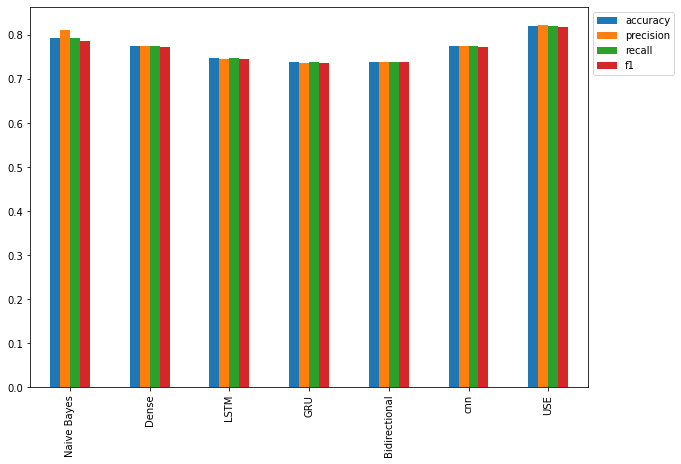

In [74]:
# Plot results
model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0)); # 'anchor' legend outside graph

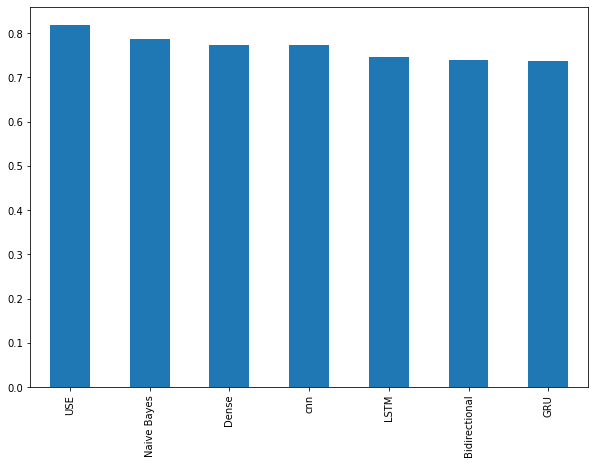

In [75]:
# Sort results by f1-score
model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
   --name "Natural Language Processing with Disaster Tweets" \
   --description "Comparing different types of model architectures on kaggle's Disaster Tweets" \
   --one_shot

In [ ]:
# View TensorBoard at https://tensorboard.dev/experiment/5n55zrQwS7SgnyKzDDKURA/

In [ ]:
# View past TensorBoard experiments
# !tensorboard dev list

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id 5n55zrQwS7SgnyKzDDKURA

#Make predictions on the test set

In [77]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10) # Random predictions on 10 samples at a time
for test_sample in test_samples:
  pred_prob = tf.squeeze(USE_model.predict([test_sample])) # The model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.10758095979690552
Text:
@Stretcher @Grazed @witter @Rexyy @Towel thanks aiden

-----

1/1 [==============================] - 0s 32ms/step
Pred: 1, Prob: 0.9218023419380188
Text:
Militant 'Overpowered' By Hostages After Attack http://t.co/xWnp8a1JOn

-----

1/1 [==============================] - 0s 31ms/step
Pred: 1, Prob: 0.9990298748016357
Text:
This Palestinian family was lucky but hundreds are feared dead in the latest boat disaster in the Mediterranean
https://t.co/cT5v3LcNKD

-----

1/1 [==============================] - 0s 30ms/step
Pred: 0, Prob: 0.06866447627544403
Text:
Want to meet @incubusband? Earn your way by watching @thematthewcooke's #SurvivorsGuidetoEarth! #Incubustour2015 - http://t.co/QW5XcXenRD

-----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.12210538983345032
Text:
We had a room full of people lifting up Collide in prayer!! We are so excited for Friday night!! http://t.

# References

See in depth tutorial on NLP at [TensorFlow Developer Certificate in 2023](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/).